# predict philly property price

The goal of this project is to predict the value of homes in Philadelphia and identify features that drive up home value. 

Property data is sourced from OpenDataPhilly and the City of Philadelphia Office of Property Assessment: https://www.phila.gov/property/data/#

Info features in the dataset were downloaded from this url: https://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/

In addition to the information in the above dataset, additional information on school locations will be used to calculate proximity to schools: https://www.opendataphilly.org/dataset/schools/resource/8e1bb3e6-7fb5-4018-95f8-63b3fc420557

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error,median_absolute_error, mean_squared_error, max_error

In [3]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [4]:
plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

## Load the cleaned data and split into training and test sets

In [5]:
df = pd.read_pickle('interim_data/df_cleaned')
df['zip_code'] = df['zip_code'].astype('category')

target = 'market_value'
target_y = df[target]
X = df.drop(target,axis=1)

In [6]:
catdf = X.select_dtypes('category')
numdf = X.select_dtypes(['float','int'])

In [7]:
dummydf = pd.get_dummies(catdf)
numdumdf = pd.concat([numdf,dummydf],axis=1)

In [8]:
from sklearn.model_selection import train_test_split 
interimdatadir = 'interim_data'

if os.path.exists(os.path.join(interimdatadir,'X_train.pkl')) == False:
    X_train,X_test,y_train,y_test = train_test_split(numdumdf,target_y,test_size=0.3,random_state=123)
    X_train.to_pickle(os.path.join(interimdatadir,'X_train.pkl'))
    X_test.to_pickle(os.path.join(interimdatadir,'X_test.pkl'))
    y_train.to_pickle(os.path.join(interimdatadir,'y_train.pkl'))
    y_test.to_pickle(os.path.join(interimdatadir,'y_test.pkl'))
else:
    X_train = pd.read_pickle(os.path.join(interimdatadir,'X_train.pkl'))
    X_test = pd.read_pickle(os.path.join(interimdatadir,'X_test.pkl'))
    y_train = pd.read_pickle(os.path.join(interimdatadir,'y_train.pkl'))
    y_test = pd.read_pickle(os.path.join(interimdatadir,'y_test.pkl'))

In [9]:
# pull out numerical columns from X_train and scale

if os.path.exists(os.path.join(interimdatadir,'X_scaled_train.pkl')) == False:
    from sklearn.preprocessing import StandardScaler
    numeric_x_train_cols = X_train.select_dtypes(['float','int']).columns
    SS = StandardScaler()
    SS.fit(X_train[numeric_x_train_cols])

    X_scaled_train = X_train.copy()
    X_scaled_test = X_test.copy()

    X_scaled_train[numeric_x_train_cols] = SS.transform(X_train[numeric_x_train_cols])
    X_scaled_test[numeric_x_train_cols]  = SS.transform(X_test[numeric_x_train_cols])

    X_scaled_train.to_pickle(os.path.join(interimdatadir,'X_scaled_train.pkl'))
    X_scaled_test.to_pickle(os.path.join(interimdatadir,'X_scaled_test.pkl'))
else:
    X_scaled_train = pd.read_pickle(os.path.join(interimdatadir,'X_scaled_train.pkl'))
    X_scaled_test = pd.read_pickle(os.path.join(interimdatadir,'X_scaled_test.pkl'))

## Train several models and compare how they perform

In [10]:
modeldir = 'models'
scaled = ['LinearRegression']

In [11]:
def fitModel(mdl,model_name,params,scaled):
    start_time = datetime.now()
    mdl_cv  = GridSearchCV(mdl,params,cv=KFold(5),verbose=0)
    
    if mdl.__class__.__name__ in scaled:
        mdl_cv.fit(X_scaled_train,y_train)
    else:
        mdl_cv.fit(X_train,y_train)

    delta_time = datetime.now()-start_time
    print(str(delta_time.seconds/60) + ' minutes')

    mdl_fname = os.path.join(modeldir,model_name)
    with open(mdl_fname, "wb") as f:
        pickle.dump(mdl_cv, f)
    f.close()

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

mdl = LinearRegression()
mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

if os.path.exists(mdl_fname) == False:
    k = [k+1 for k in range(len(X_scaled_train.columns))]
    
    params = {'selectkbest__k': k}
    
    fitModel(make_pipeline(SelectKBest(f_regression),LinearRegression()),mdl.__class__.__name__,params,scaled)

In [13]:
from sklearn.tree import DecisionTreeRegressor

mdl = DecisionTreeRegressor()

mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

if os.path.exists(mdl_fname) == False:
    max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
    min_samples_leaf = [int(x) for x in np.linspace(10, 500, num = 10)]
    max_features = [0.7,0.9,1.0]
    params = {'max_depth':max_depth,
              'min_samples_leaf': min_samples_leaf,
              'max_features':max_features}
    fitModel(mdl,mdl.__class__.__name__,params,scaled)

In [14]:
from lightgbm import LGBMRegressor as lightgbm

mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

if os.path.exists(mdl_fname) == False:
    max_depth  = [int(x) for x in np.linspace(3, 12, num = 3)]
    num_leaves = [int(round(x**2)) for x in max_depth]
    learning_rate = [float(x) for x in np.linspace(start = 0.05, stop = 0.3, num = 3)]
    min_data_in_leaf = [int(x) for x in np.linspace(50, 500, num = 5)]

    params = {'num_leaves':num_leaves,
          'max_depth': max_depth,
          'learning_rate':learning_rate,
          'metric':['auc','binary_logloss'],
          'min_data_in_leaf':min_data_in_leaf}

    fitModel(mdl,mdl.__class__.__name__,params,scaled)

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

mdl = GradientBoostingRegressor()

mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

if os.path.exists(mdl_fname) == False:
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 3)]
    max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
    learning_rate = [float(x) for x in np.linspace(start = 0.05, stop = 0.3, num = 3)]

    params = {'n_estimators':n_estimators, 
         'max_depth':max_depth,
         'learning_rate':learning_rate,
         'subsample':[0.7,1.0],
         'max_features':[0.8],
         'min_samples_leaf':[0.05]}

    fitModel(mdl,mdl.__class__.__name__,params,scaled)

In [16]:
from sklearn.ensemble import RandomForestRegressor

mdl = RandomForestRegressor()

mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

if os.path.exists(mdl_fname) == False:
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 2)]
    max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
    max_depth.append(None)

    params = {'n_estimators':n_estimators, 
         'max_depth':max_depth,
         'bootstrap':[True,False],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'max_features': ['auto', 'sqrt']}

    fitModel(mdl,mdl.__class__.__name__,params,scaled)

## Load trained models and gather scores on how they perform

In [17]:
models = []
meanae = []
medianae = []
mse = []
maxerr = []
model_files = os.listdir(modeldir)
cvmeans = list()
cvstds = list()

for file in model_files:
    if file[0] == '.':
        continue
    if file.__contains__('shuf'):
        continue
    mdl = pd.read_pickle(os.path.join(modeldir,file))
    y_pred = mdl.predict(X_test)
    models.append(file)
    meanae.append(mean_absolute_error(y_test,y_pred))
    medianae.append(median_absolute_error(y_test,y_pred))
    mse.append(mean_squared_error(y_test,y_pred))
    maxerr.append(max_error(y_test,y_pred))
    
    best_mdl_idx = mdl.cv_results_['rank_test_score'] == 1
    cvmeans.append(mdl.cv_results_['mean_test_score'][best_mdl_idx][0])
    cvstds.append(mdl.cv_results_['std_test_score'][best_mdl_idx][0])

results = pd.DataFrame({'model':models,'mse':mse,'median_abs_err':medianae,'mean_abs_err':meanae,'max_error':maxerr})
results = results.set_index('model')
results = results.sort_values('mse',ascending=True)
results

,mse,median_abs_err,mean_abs_err,max_error
model,,,,
LGBMRegressor,3.697791e+08,5998.928477,10804.828278,199488.141720
RandomForestRegressor,3.955033e+08,3578.800000,9765.215333,209663.600000
GradientBoostingRegressor,4.213431e+08,7192.435051,12491.115945,217864.600107
DecisionTreeRegressor,7.640186e+08,7474.901961,15910.687450,242984.615385
LinearRegression,1.034700e+09,15989.972313,22667.427275,186653.617355


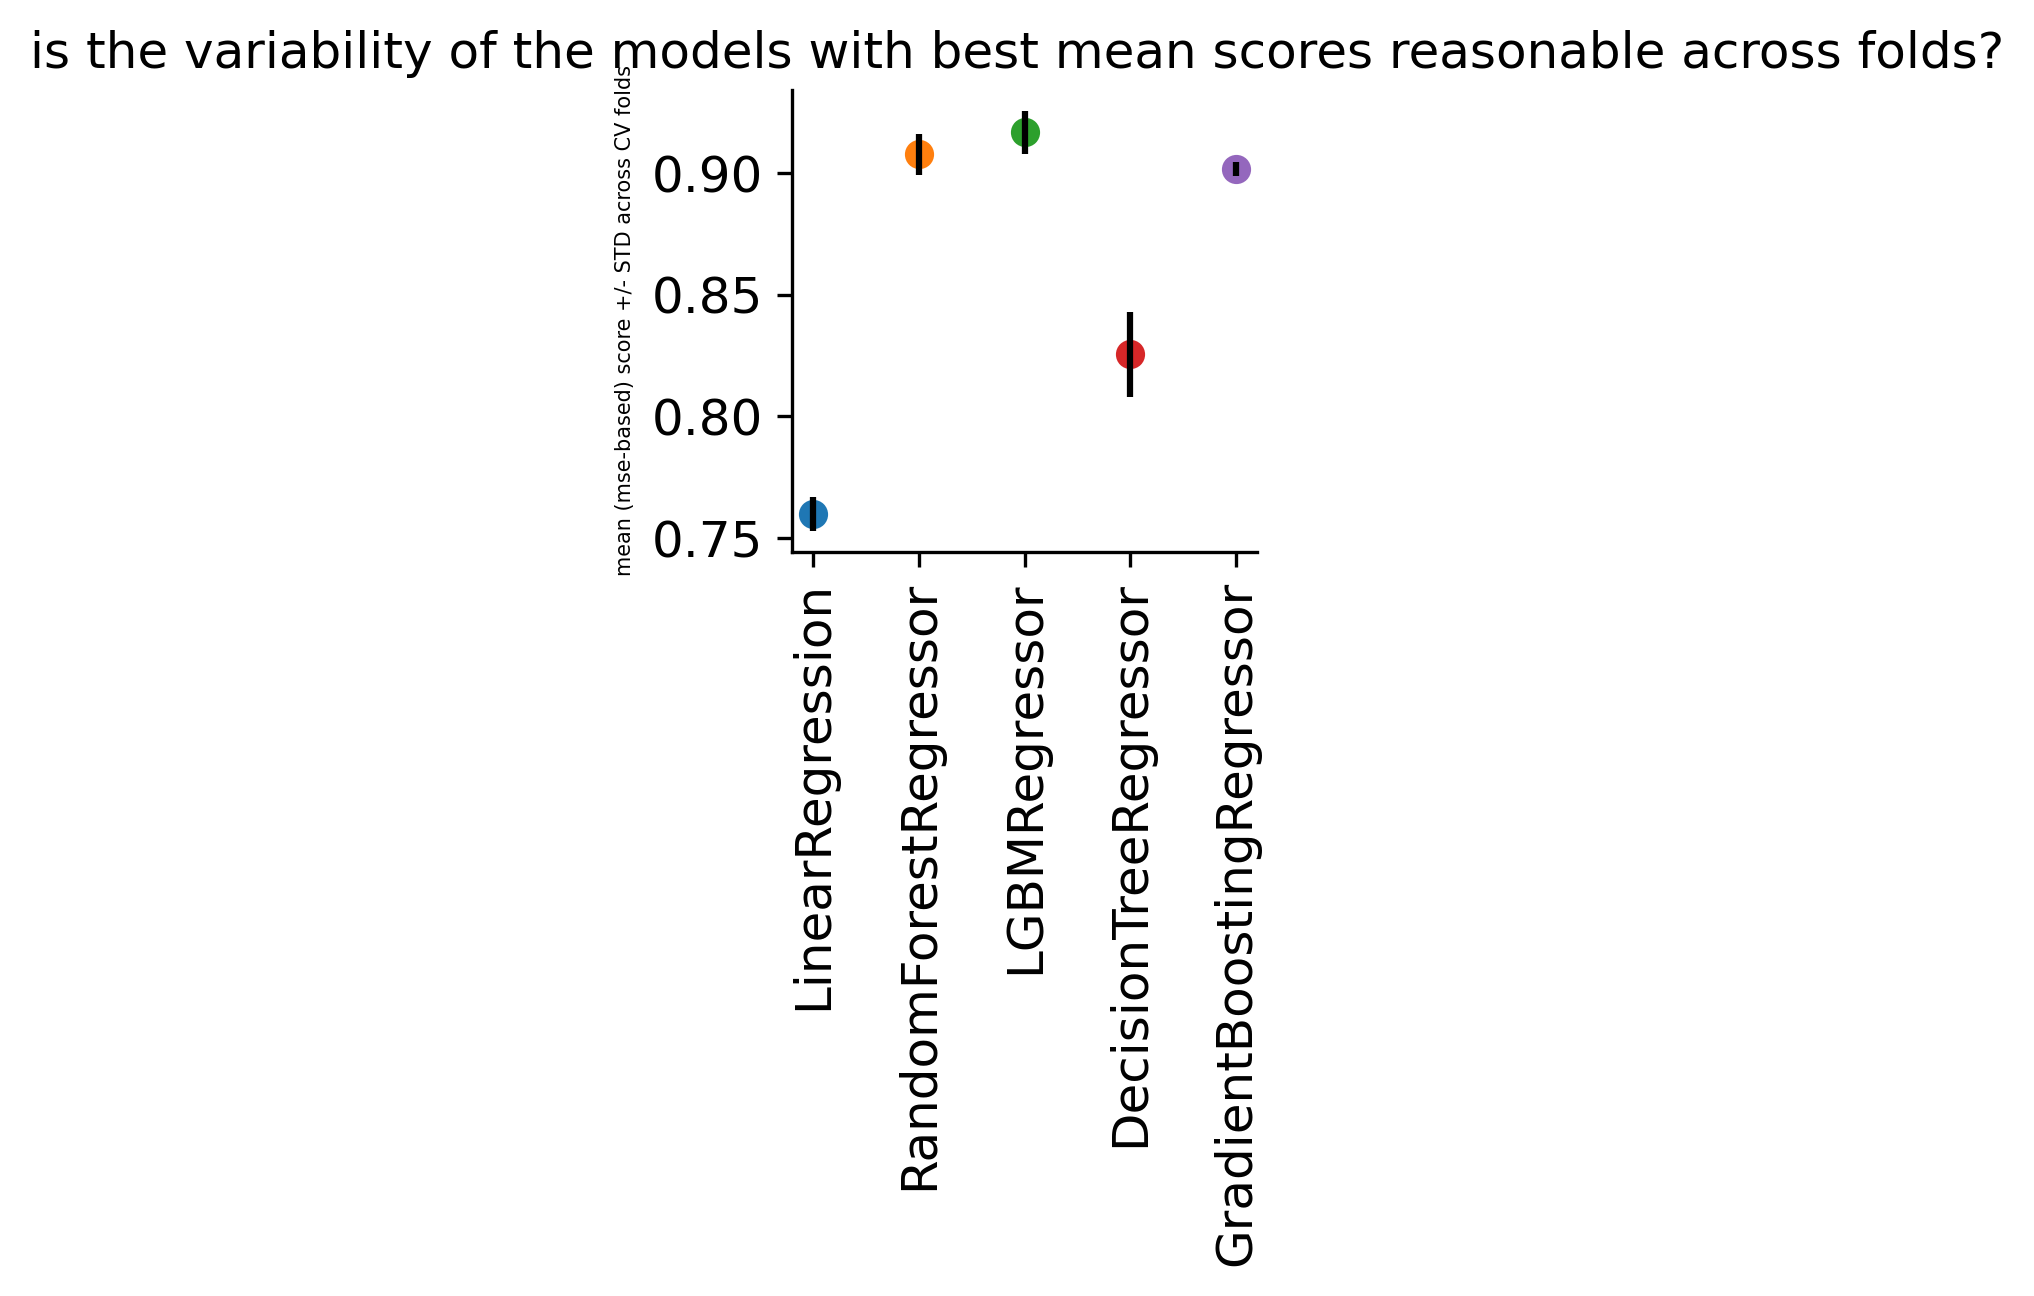

In [18]:
fig = plt.subplots(figsize=(2,2))
for idx in range(len(models)):
    plt.plot(models[idx],cvmeans[idx],marker='o')
    plt.errorbar(models[idx],cvmeans[idx],cvstds[idx],color=[0,0,0])
sns.despine()
plt.suptitle('is the variability of the models with best mean scores reasonable across folds?')
plt.ylabel('mean (mse-based) score +/- STD across CV folds',fontsize=5)
plt.xticks(rotation=90)
plt.show()

In [19]:
colors = plt.cm.get_cmap('tab20')
its = np.linspace(0,1,num=int(len(model_files)))

In [20]:
cnt = 0
colordict = {}
for index in results.index:
    colordict[index] = colors(its[cnt])
    cnt += 1

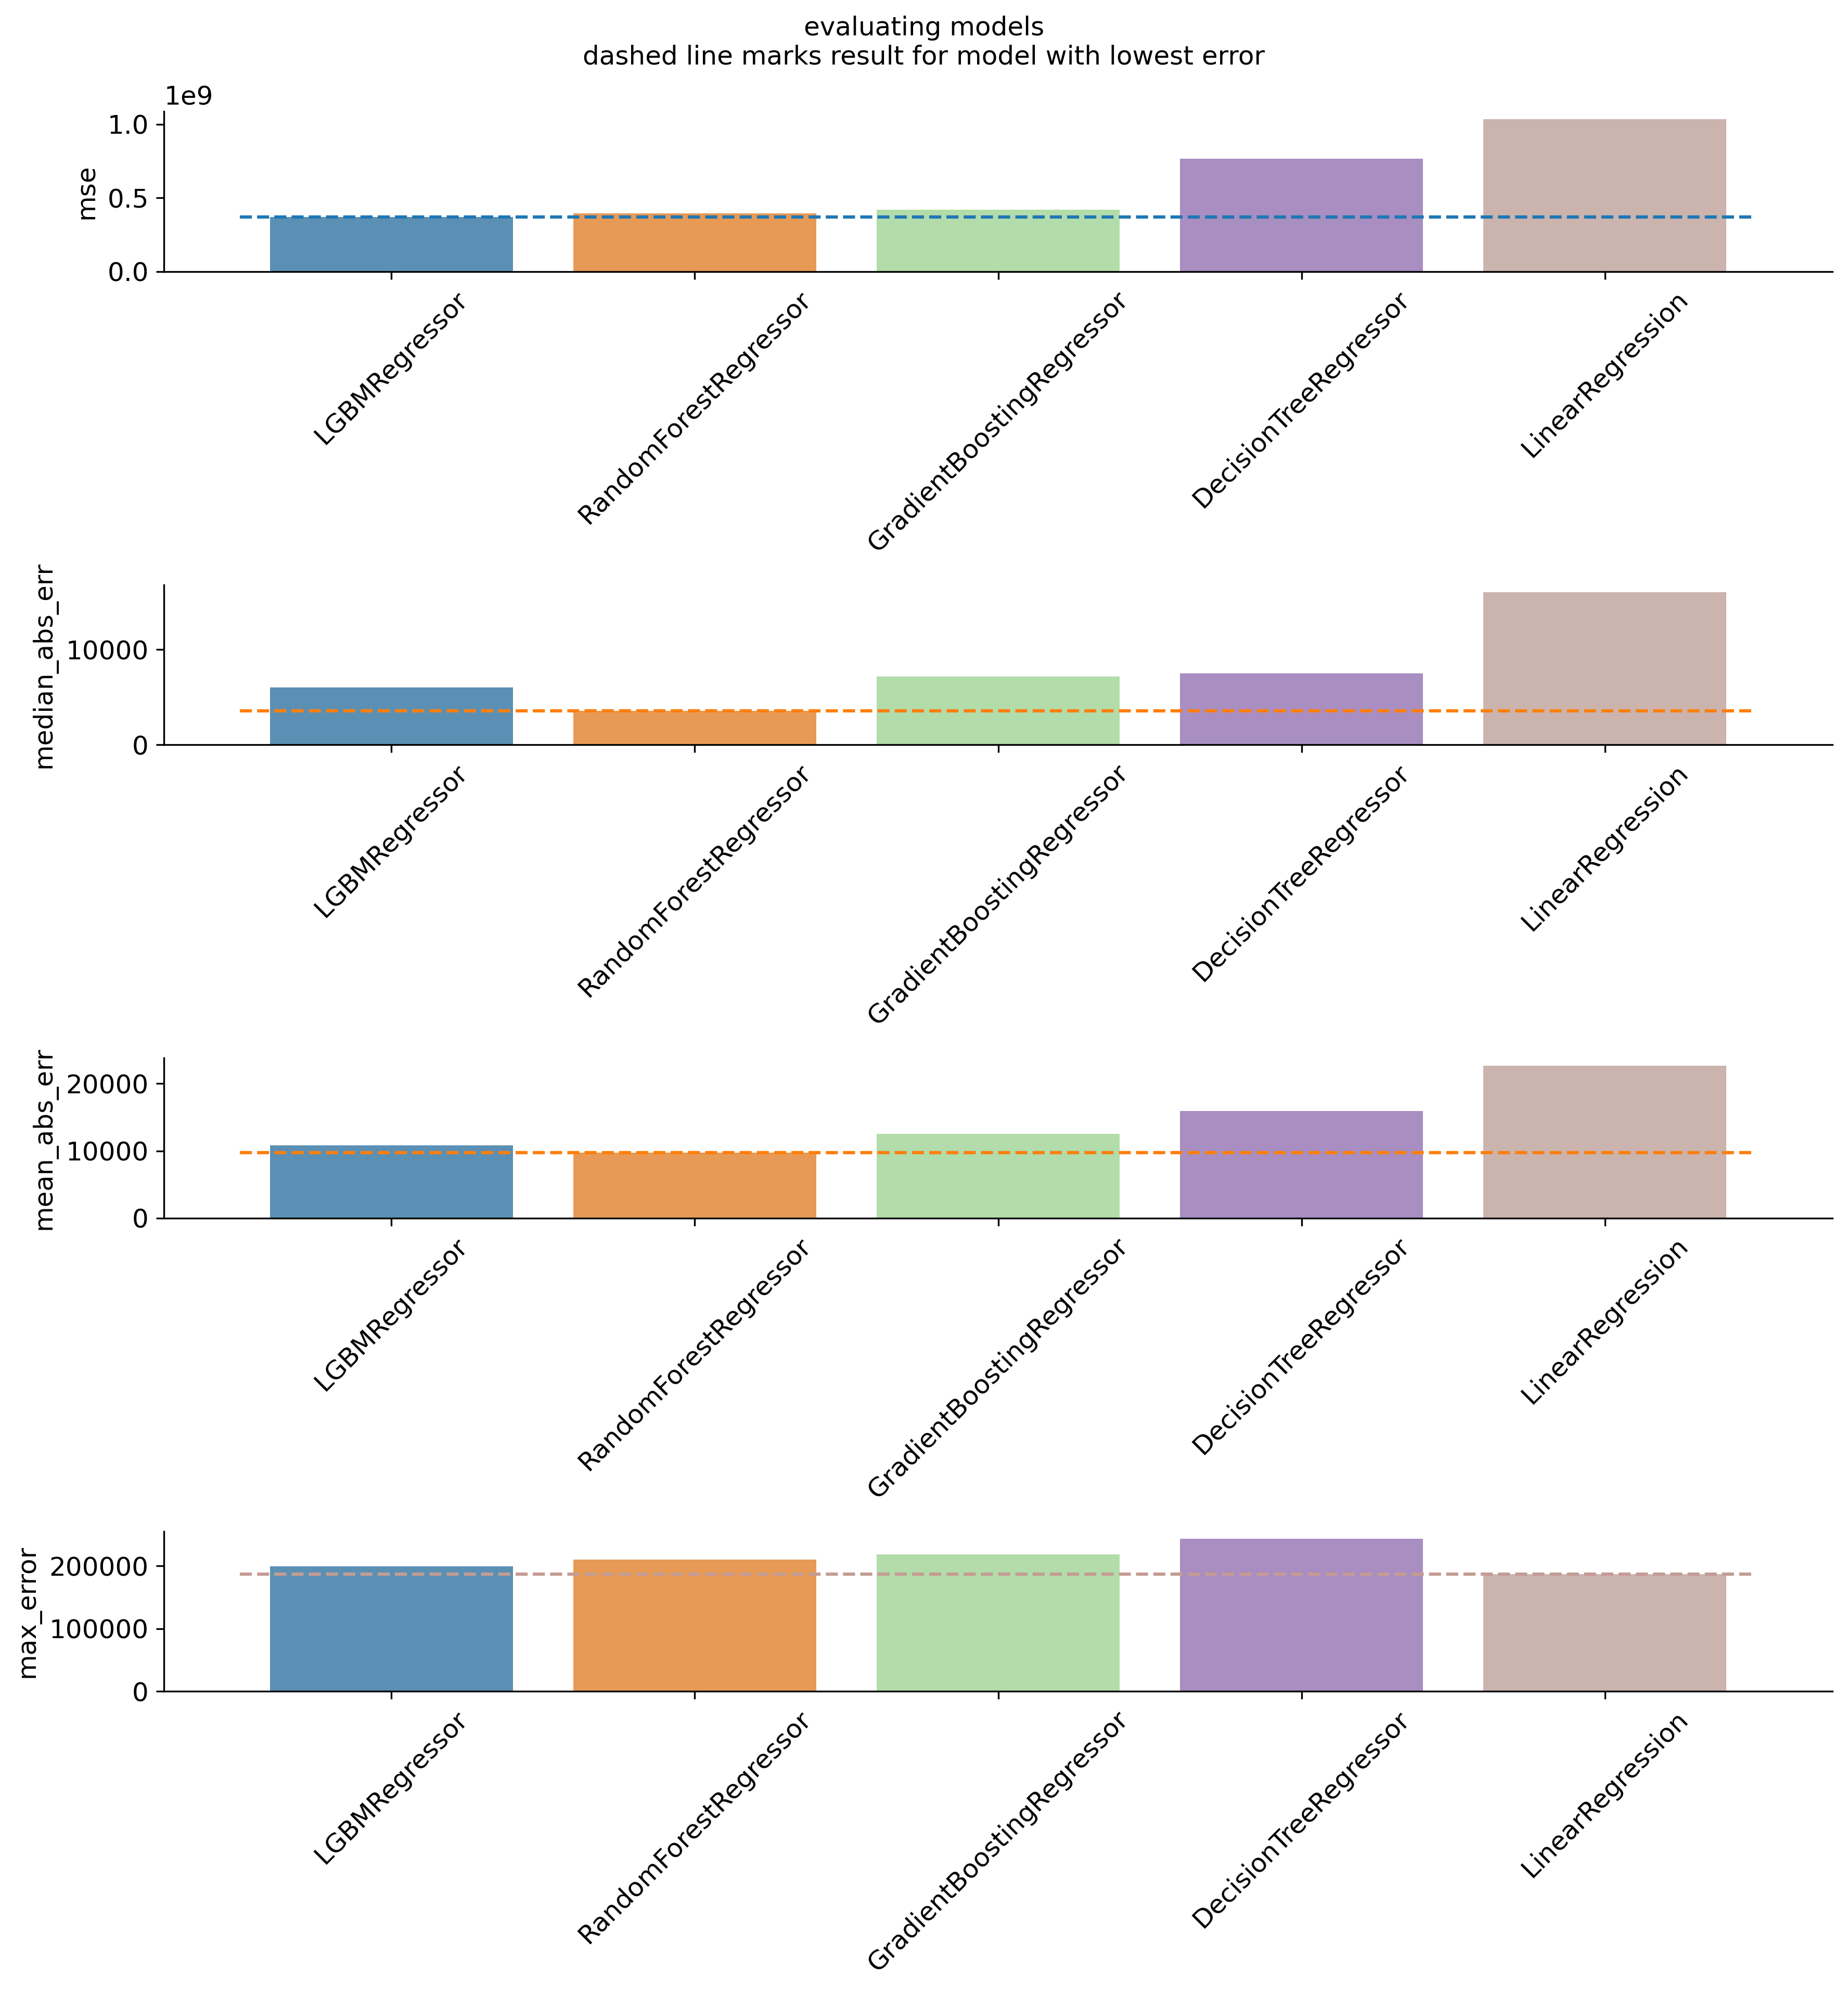

In [21]:
fig,ax=plt.subplots(nrows=4,ncols=1,figsize=(12,13))
cnt = 0
for column in results:
    bars = sns.barplot(data=results,x=results.index,y=column,ax=ax[cnt],palette=colordict,alpha=0.8)
    sns.despine()
    mn = min(results[column])
    win = list(results[results[column] == min(results[column])].index)
    ax[cnt].hlines(mn,-.5,results.shape[0]-.5,linestyle='--',color=colordict[win[0]])
    ax[cnt].set_xlabel('')
    for item in bars.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
    plt.suptitle('evaluating models\ndashed line marks result for model with lowest error',fontsize=12)
    cnt += 1

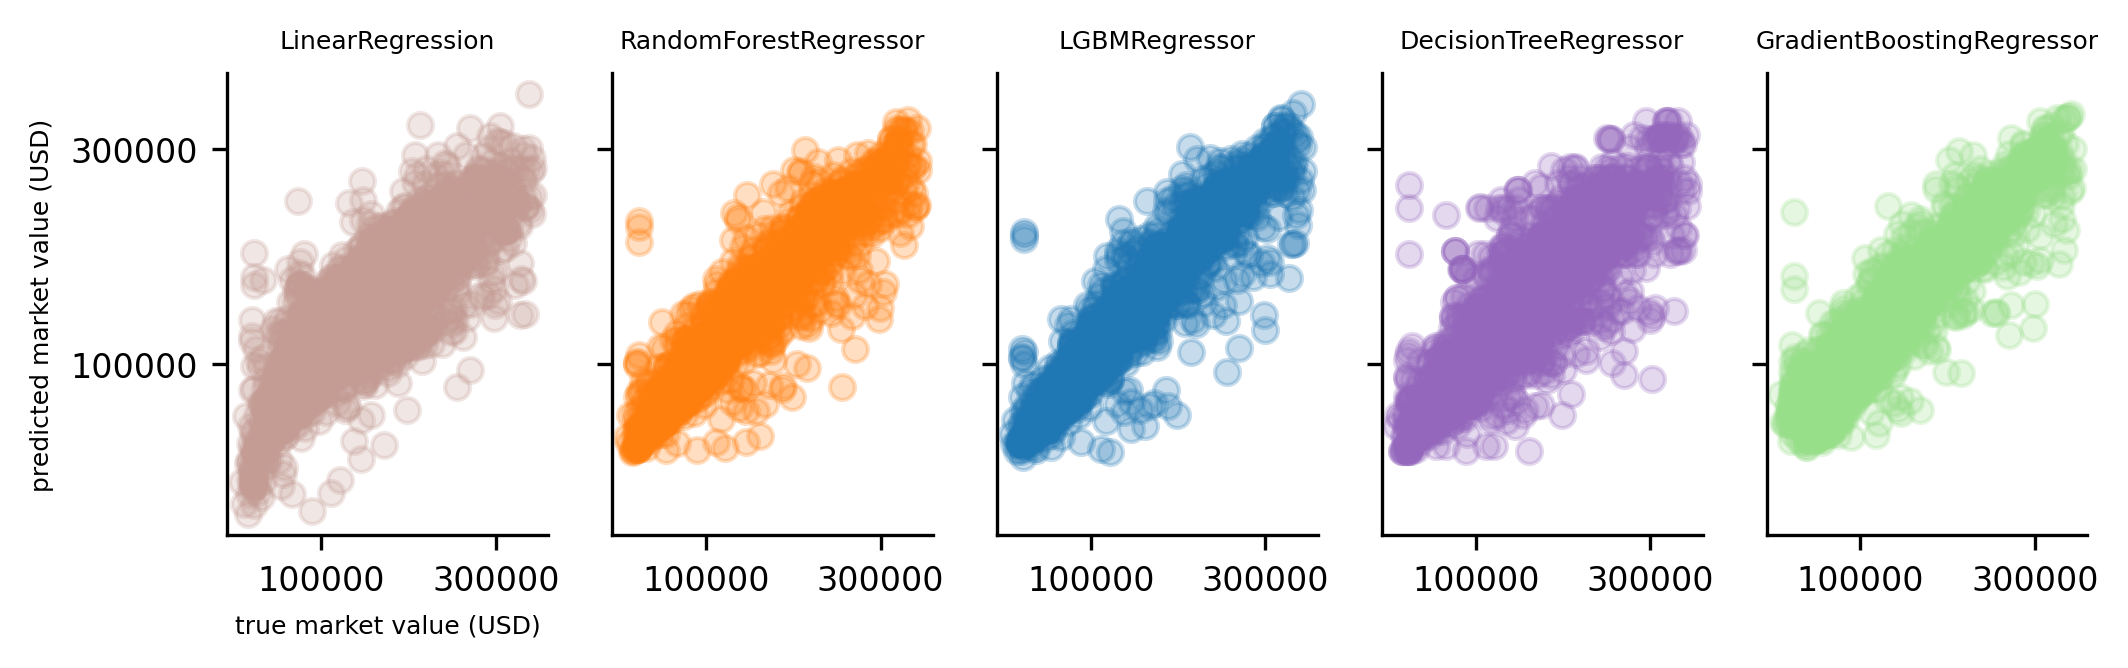

In [22]:
model_files = os.listdir(modeldir)

cnt = 0
plt.rcParams['font.size'] = 8

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(8,2),sharey=True,sharex=True)
for file in model_files:
    if file[0] == '.':
        continue
    if file.__contains__('shuf'):
        continue
    mdl = pd.read_pickle(os.path.join(modeldir,file))
    y_pred = mdl.predict(X_test)

    ax[cnt].scatter(y_test,y_pred,alpha=0.25,color=colordict[file])

    ax[cnt].set_xticks(ticks=[100000,300000],rotation=45)
    ax[cnt].set_yticks(ticks=[100000,300000],rotation=45)
    ax[cnt].set_title(file,fontsize=6)
    if cnt == 0:
        ax[cnt].set_ylabel('predicted market value (USD)',fontsize=6)
        ax[cnt].set_xlabel('true market value (USD)',fontsize=6)
    sns.despine()
    cnt += 1
plt.suptitle('')
plt.show()  

The LGBMRegressor model (histogram based) and the DecisionTreeRegressor perform similarly. Because this project is based on homes with values that are close to the median (outliers removed) and because LGBMRegressor trained orders of magnitude faster than the DecisionTreeRegressor, we will go with the the LGBMRegressor. This way we can also run a permutation test and see how it compares to a random model.

## Run permutation test to see how chosen model compares to shuffled data

In [23]:
mdl = pd.read_pickle(os.path.join(modeldir,'LGBMRegressor'))

In [24]:
if os.path.exists(os.path.join(modeldir,'shufmse')) == False:

    import itertools
    warnings.filterwarnings(action='ignore')
    niterations = 100
    shufmedianae = list()
    shufmse = list()
    for i in range(niterations):
        mdl = lightgbm()
        mdl_fname = os.path.join(modeldir,mdl.__class__.__name__)

        max_depth  = [int(x) for x in np.linspace(3, 12, num = 3)]
        num_leaves = [int(round(x**2)) for x in max_depth]
        learning_rate = [float(x) for x in np.linspace(start = 0.05, stop = 0.3, num = 3)]
        min_data_in_leaf = [int(x) for x in np.linspace(50, 500, num = 5)]

        params = {'num_leaves':num_leaves,
          'max_depth': max_depth,
          'learning_rate':learning_rate,
          'metric':['auc','binary_logloss'],
          'min_child_samples':min_data_in_leaf}

        start_time = datetime.now()
        mdl_cv  = GridSearchCV(mdl,params,cv=KFold(5),verbose=0)
        y_train_shuf = list(itertools.chain(*np.random.choice(y_train.ravel(),size=(len(y_train.ravel()),1),replace=False)))
        mdl_cv.fit(X_train,y_train_shuf)
        y_pred = mdl_cv.predict(X_test)
        shufmedianae.append(median_absolute_error(y_test,y_pred))
        shufmse.append(mean_squared_error(y_test,y_pred))
    
        delta_time = datetime.now()-start_time
        print(str(i) + ' elapsed time ' + str(delta_time))
else:
    with open(os.path.join(modeldir,'shufmse'), "rb") as f:
        shufmse = pickle.load(f)
    f.close()

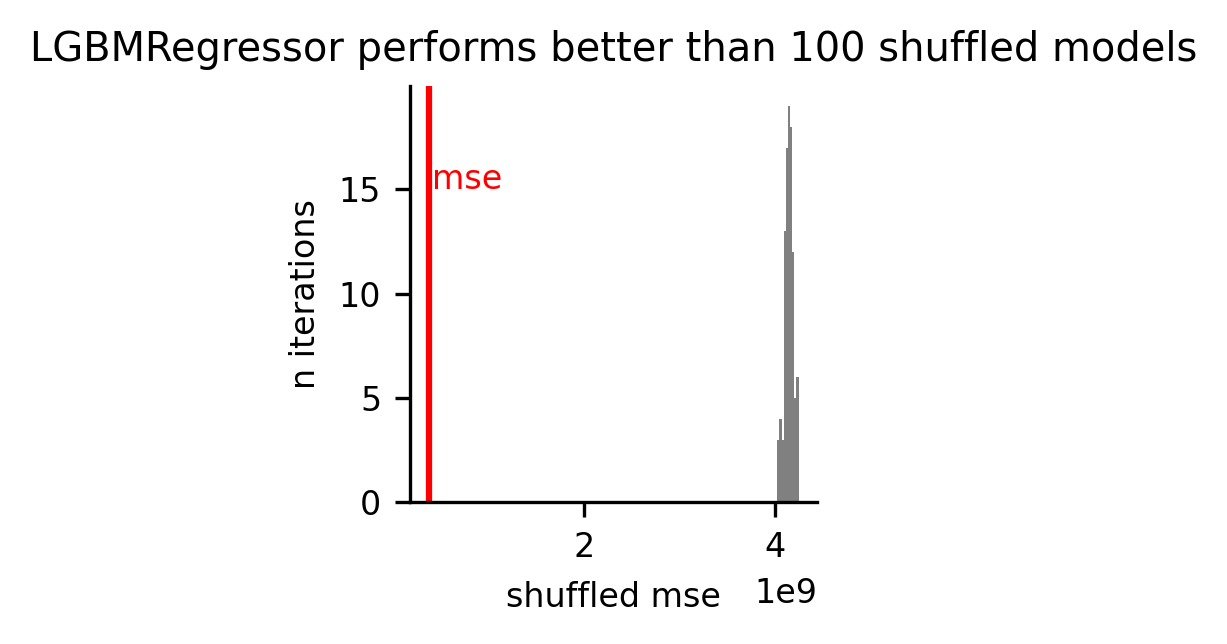

In [25]:
fig = plt.figure(figsize=(2,2))
plt.hist(shufmse,color=[0.5,0.5,0.5])
plt.axvline(results.loc['LGBMRegressor']['mse'],color='r')
plt.text(x=results.loc['LGBMRegressor']['mse']*1.1,y=15,s='mse',color='r')
sns.despine()
plt.xlabel('shuffled mse')
plt.ylabel('n iterations')
plt.tight_layout()
plt.title('LGBMRegressor performs better than 100 shuffled models')
plt.show()

Looks like our trained LGBMRegressor model performs better than all 100 random models trained on shuffled data. 

In [26]:
df = pd.read_pickle(os.path.join(interimdatadir,'df_cleaned'))
target_y = df[target]
features = df.columns
features = features.drop(target)
X = df.drop(target,axis=1)

Now we can train the LGBMRegressor model on all data. This way we can use all data to get a better sense of model error (through cross validation). We can also use all of the data to check features that are most important for predicting home value.

In [31]:
if os.path.exists(os.path.join(modeldir,'fullmdl')) == False:
    from lightgbm import LGBMRegressor

    fullmdl=LGBMRegressor()
    fullmdl.fit(X,target_y)

    with open(os.path.join(modeldir,'fullmdl'),"wb") as f:
        pickle.dump(fullmdl,f)
    f.close()
else:
    with open(os.path.join(modeldir,'fullmdl'),"rb") as f:
        fullmdl = pickle.load(f)   

In [32]:
from sklearn.model_selection import cross_validate 
cv_results = cross_validate(fullmdl, X, target_y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std 

(10928.432019269687, 182.67643914047906)

The results from cross validation on the full dataset indicate that we can expect actual market value of a home to be the model's predictions 